# Erdös-Renyi

### Libraries

In [60]:
## libs 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## Keras
from keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

## Basic
from tqdm import tqdm_notebook as tqdm
import argparse
import os
import random
import itertools

# Computation
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
import scipy
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr 

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Network Processing
import networkx as nx
from networkx.generators import random_graphs

## Loading and Preprocessing Network Data

### Loading Network Data

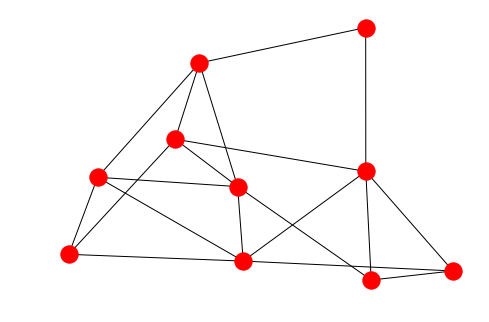

In [61]:
def random_graph(n,p): 

    g = random_graphs.erdos_renyi_graph(n, p, seed=None, directed=False)
    dh = nx.degree_histogram(g)

    nx.draw(g)
    plt.show()

random_graph(n = 10, p = 0.4)

### Preprocessing

In [62]:
## Sorting rows by node degree (decreasing)

def sort_adjacency(g):
        
    node_k1 = dict(g.degree())                  # sort by degree
    node_k2 = nx.average_neighbor_degree(g)     # sort by neighbor degree
    node_closeness = nx.closeness_centrality(g) 
    node_betweenness = nx.betweenness_centrality(g) 

    node_sorting = list()
    
    for node_id in range(0, len(g)):
        node_sorting.append((node_id, node_k1[node_id], node_k2[node_id], node_closeness[node_id], node_betweenness[node_id]))
        
    node_descending = sorted(node_sorting, key = lambda x: (x[1], x[2]), reverse=True)
    
    mapping = dict()
    
    for i, node in enumerate(node_descending):
        
        mapping[node[0]] = i
            
    a = nx.adjacency_matrix(g, nodelist= mapping.keys()).todense()    
    g = nx.relabel_nodes(g, mapping)
    
    return g, a


## obtain the upper triangle of adjacency matrix without diagonal

def upper_triangle(a, diag_offset, node_features = None):
    
    
    if diag_offset >= 0:  ## obtain upper triangle of graph
        
        upper_a = np.ravel(a[np.triu_indices(a.shape[0], k = diag_offset)])

    else:           ## keep entire adjacency matrix
        upper_a = np.reshape(a,(a.shape[0], a.shape[0], 1)) ## reshape to add channel 1
    
    return upper_a




## calculate the area of upper triangle of sorted adjacency matrix

def calculate_A_shape(n, diag_offset):
    
    if diag_offset == 0:
        return (int(((n*n)/2)+(n/2)),)
    
    elif diag_offset == 1:
        return (int(((n*n)/2)-(n/2)),)
    
    elif diag_offset == -1:           # keep entire adjacency matrix
        return (n, n, 1) 


    

## construct adjacency matrix from flattened upper_triangle

def reconstruct_adjacency(upper_a, clip, diag_offset):
    
    ## if first element is 1 --> squeeze it
    if upper_a.shape[0] == 1:
        upper_a = np.squeeze(upper_a)

    ## from upper triangle to adjacency matrix    
    if diag_offset == 1:  
        a = squareform(upper_a, force='no', checks=True)
        
    elif diag_offset == 0:
        n = int(-1 + np.sqrt(1 + 8*len(upper_a))) // 2
        iu1 = np.triu_indices(n)
        a = np.empty((n, n))
        a[iu1] = upper_a
        a.T[iu1] = upper_a
        
    else:
        a = upper_a
           

    ## clip values to binary
    if clip == True:
        
        a[a>=0.5] = 1
        a[a<0.5] = 0
               
    return a



## pad the adjacency matrix to adhere to fixed size n_max

def pad_matrix(a, n_max, fill_diag):

    ## fill the diagonal with fill_diag
    np.fill_diagonal(a, fill_diag)

    max_adjacency = np.zeros([n_max, n_max])
    max_adjacency[:a.shape[0],:a.shape[1]] = a

    return max_adjacency



## unpad the adjacency matrix by looking at diagonal values

def unpad_matrix(max_adjacency, diag_value, fix_n):
    
    if fix_n == False:
        
        keep = list()
        for i in range(0, max_adjacency.shape[0]):
            if max_adjacency[i][i] == diag_value:
                keep.append(i)

        ## delete rows and columns
        max_adjacency = max_adjacency[:,keep] # keep columns
        max_adjacency = max_adjacency[keep,:] # keep rows
            
    return max_adjacency



def prepare_in_out(T, diag_offset, A_shape):
    
    T = np.asarray(T)

    if diag_offset >= 0:  # vector input
        return T, (A_shape[0],), A_shape[0] 
    else:                 # matrix input
        return T, (A_shape[0], A_shape[1], 1), (A_shape[0], A_shape[1], 1)
    
        
    
    
    

## Preprocess Graph____________________________________

g, a = sort_adjacency(g)
upper_a = upper_triangle(a, diag_offset = 0)
reconstructed_a = reconstruct_adjacency(upper_a, clip = True, diag_offset = 0)

max_adjacency = pad_matrix(a, 50, 1)
a = unpad_matrix(max_adjacency, 1, False)


# Generating Training Data

In [98]:
def generate_data(dataArgs): 
    
    ## Data ________________________________

    G = np.zeros((dataArgs["n_graphs"], *calculate_A_shape(dataArgs["n_max"], diag_offset = dataArgs["diag_offset"])))

    ## Ground Truth Labels ______________________________

    T = list()

    ## Generate Graph Data_______________________________

    for i in tqdm(range(0,dataArgs["n_graphs"])):

        ## Generate Graph Type ______________________________________________

        if dataArgs["fix_n"] == True:
            n = dataArgs["n_max"] # generate fixed number of nodes n_max
        else:
            n = random.randint(1, dataArgs["n_max"]) # generate number of nodes n between 1 and n_max and

        p = np.random.rand(1)  # float in range 0 - 1 
        g = random_graphs.erdos_renyi_graph(n, p, seed=None, directed=False)

        g, a = sort_adjacency(g)
        a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
        a_transformed = upper_triangle(a, diag_offset = dataArgs["diag_offset"])


        ## Generate Ground Truth features____________________________________

        if nx.is_connected(g):
            diameter = nx.diameter(g)
        else:
            diameter = -1

        density = nx.density(g)

        ## toDO: add more graph topologies and figure out good data structure - dicts?


        ## Build Data Arrays___________________________________________________

        G[i] = a_transformed

        t = dict()
        t["p"] = p
        t["n"] = n
        t["diameter"] = diameter
        t["density"] = density

        T.append(t)



    ## Input and Output Size ___________________________________________________________

    T, input_shape, output_shape = prepare_in_out(T, dataArgs["diag_offset"], calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"]))
    print("input_shape:", input_shape, ", output_shape:", output_shape)
    
    return G,T,input_shape,output_shape
    
dataArgs = {"n_graphs": 10000, "n_max": 24, "fix_n": False, "diag_offset": -1, "diag_value": 1, "clip": True}  #"diag_offset" - 1 == full adjacency
G, T, input_shape, output_shape = generate_data(dataArgs)


input_shape: (24, 24, 1) , output_shape: (24, 24, 1)


# beta-VAE (MLP, Conv)

## Build Model

In [120]:
# network parameters
modelArgs = {"nn_architecture": "conv", "latent_dim": 2, "filters": 16, "kernel_size": 3, "input_shape": input_shape, "output_shape": output_shape}


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



## MODEL ______________________________________________________________

## Multi-layer Perceptron without convolutions__________________________________

if modelArgs["nn_architecture"] == "mlp":

    ## 1) build encoder model
    inputs = Input(shape=modelArgs["input_shape"], name='encoder_input')
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(x)
    z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(x)

    ## 2) build decoder model
    latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
    y = Dense(64, activation='relu')(latent_inputs)
    y = Dense(128, activation='relu')(y)
    outputs = Dense(modelArgs["output_shape"], activation='sigmoid')(y)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(modelArgs["latent_dim"],), name='z')([z_mean, z_log_var])


    ## INSTANTIATE ________________________________________________

    ## 1) instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    #plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

    ## 2) instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    decoder.summary()
    #plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

    ## 3) instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_graph')
    #vae.summary()





## Convolutional Neural Network_________________________________

if modelArgs["nn_architecture"] == "conv":


    ## 1) build encoder model____________________________________

    inputs = Input(shape=modelArgs["input_shape"], name='encoder_input')
    x = inputs

    for i in range(2):
        modelArgs['filters'] *= 2
        x = Conv2D(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'], activation='relu', strides=2, padding='same')(x)

    # shape info needed to build decoder model
    shape = K.int_shape(x)

    # generate latent vector Q(z|X)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(x)
    z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(x)



    ## 2) build decoder model____________________________________

    latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    for i in range(2):
        x = Conv2DTranspose(filters=modelArgs['filters'], kernel_size=modelArgs['kernel_size'], activation='relu', strides=2, padding='same')(x)
        modelArgs['filters'] //= 2

    outputs = Conv2DTranspose(filters=1, kernel_size=modelArgs['kernel_size'], activation='sigmoid', padding='same', name='decoder_output')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(modelArgs["output_shape"],), name='z')([z_mean, z_log_var])



    ## INSTANTIATE___________________________________

    ## 1) instantiate encoder model    
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    #plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)


    ## 2) instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    decoder.summary()
    #plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)


    ## 3) instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='conv_vae')
    #vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 24, 24, 1)    0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 12, 12, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 6, 6, 64)     18496       conv2d_13[0][0]                  
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 2304)         0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
dense_108 

## Train Model

In [140]:
## Configs  
trainArgs = {"loss": "mse", "weights": "train", "early_stop": 5, "batch_size": 128, "epochs": 100, "beta": 25, "data_split": 0.2}

## MLP: beta =
## CNN: beta =

## Train and Validation Split _______________________________________________

x_train, x_test, y_train, y_test = train_test_split(G, T, test_size= trainArgs["data_split"], random_state=1, shuffle=True)

models = (encoder, decoder)
data = (x_test, y_test)


## VAE loss = mse_loss or xent_loss + kl_loss_______________________

if trainArgs["loss"] == "mse":
    
    if modelArgs["nn_architecture"] == "mlp":
        reconstruction_loss = mse(inputs, outputs)
        reconstruction_loss *= modelArgs["input_shape"]
        
    if modelArgs["nn_architecture"] == "conv":
        reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
        reconstruction_loss *= modelArgs["input_shape"][0] * modelArgs["input_shape"][1]
        
if trainArgs["loss"] == "binary_crossentropy":
    
    if modelArgs["nn_architecture"] == "mlp":
        reconstruction_loss = binary_crossentropy(inputs, outputs)
        reconstruction_loss *= modelArgs["input_shape"]
        
    if modelArgs["nn_architecture"] == "conv":
        reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
        reconstruction_loss *= modelArgs["input_shape"][0] * modelArgs["input_shape"][1]



## LOSS _____________________________________________

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + (trainArgs["beta"] * kl_loss))
vae.add_loss(vae_loss)
vae.compile(optimizer='adam', metrics=['accuracy'])
vae.summary()
#plot_model(vae,to_file='vae_mlp.png',show_shapes=True)



## TRAIN______________________________________________

# load the autoencoder weights

if trainArgs["weights"] == "load":
    
    vae.load_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")

# train the autoencoder

elif trainArgs["weights"] == "train":
    
    # Set callback functions to early stop training and save the best model so far
    callbacks = [EarlyStopping(monitor='val_loss', patience=trainArgs["early_stop"]), ModelCheckpoint(filepath="models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5", monitor='val_loss', save_best_only=True)]
    
    vae.fit(x_train, epochs=trainArgs["epochs"], batch_size=trainArgs["batch_size"], callbacks=callbacks, validation_data=(x_test, None))
    vae.save_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 24, 24, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 55764     
_________________________________________________________________
decoder (Model)              (None, 24, 24, 1)         62593     
Total params: 118,357
Trainable params: 118,357
Non-trainable params: 0
_________________________________________________________________
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
3840/8000 [=============>................] - ETA: 3s - loss: 122.9931

KeyboardInterrupt: 

# Latent Space Analysis

# Encoder

# Iterate through single data dimension and oberseve single latent space dimension  

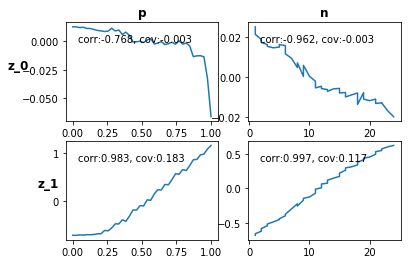

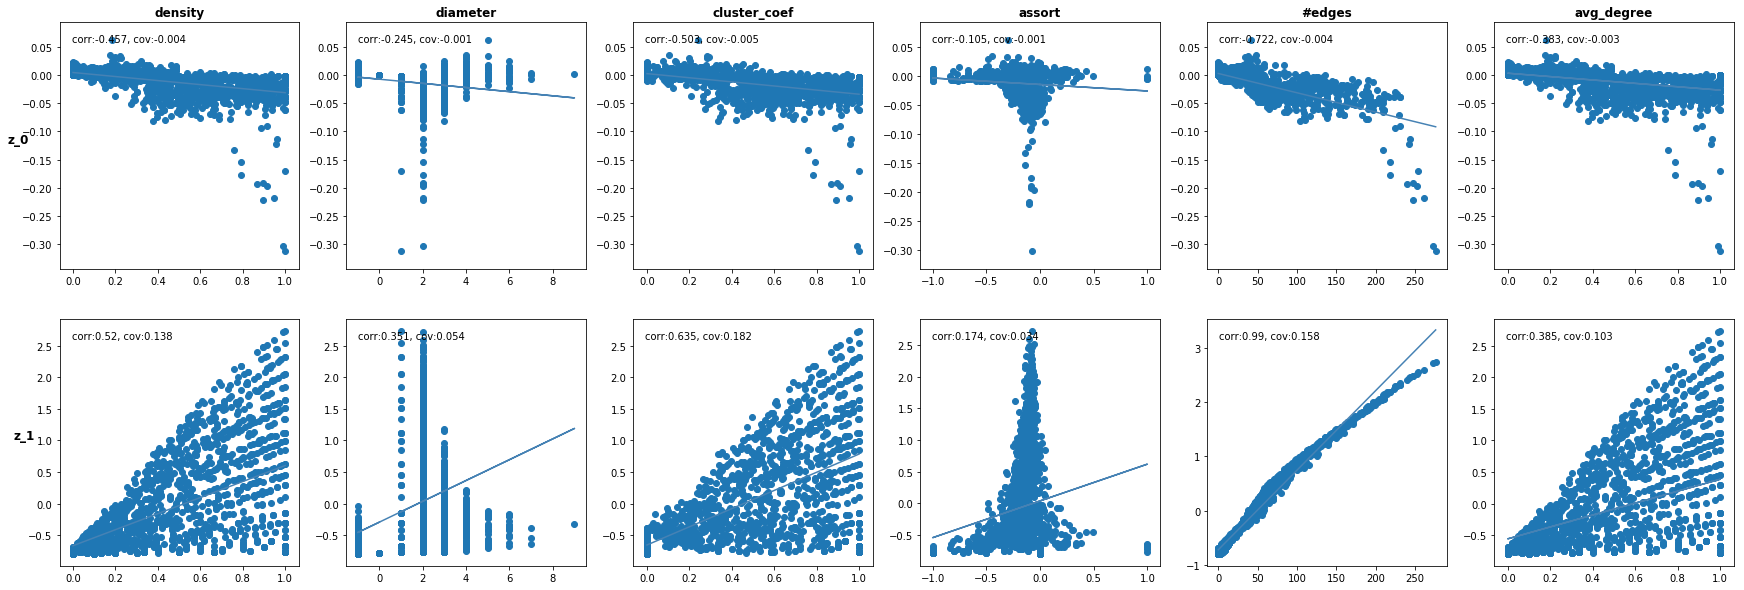

In [122]:
def latent_space_feature_correlation(analyzeArgs, models,batch_size=128,model_name="vae_graph"):

    encoder, decoder = models  # trained models

    if analyzeArgs["root_params"] == 2:
        
        ## Generate Graph Data_______________________________
    
        N = np.linspace(1,dataArgs["n_max"],analyzeArgs["n_config_graphs"], dtype=int)  # array 1,2,3,4,5 - n_max / n_config_graphs
        P = np.linspace(0,1,analyzeArgs["n_config_graphs"])  # array 0.1, 0.2 - 1 / n_config_graphs 
        
        ## growth and topol parameters
        growth_params = ["p", "n"]
        topol_params = ["density", "diameter", "cluster_coef", "assort", "#edges", "avg_degree"]

        ## store graphs and targets
        # shape: n_config_graphs, params, upper_A_size
        G = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
        Growth = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), len(growth_params)))
        Topol = np.zeros((analyzeArgs["n_config_graphs"]**len(growth_params), len(topol_params)))

        ## iterate through topological features
        graph_configs = np.asarray(list(itertools.product(P,N)))
        

        for i, (p,n) in enumerate(graph_configs):

            ## Generate Graph Type ______________________________________________

            g = random_graphs.erdos_renyi_graph(int(n), p, seed=None, directed=False)

            g, a = sort_adjacency(g)
            a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
            upper_a = upper_triangle(a, dataArgs["diag_offset"])


            ## Generate Ground Truth features____________________________________

            density = nx.density(g)

            if nx.is_connected(g):
                diameter = nx.diameter(g)
            else:
                diameter = -1

            cluster_coef = nx.average_clustering(g)

            if g.number_of_edges() > 0:
                assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            edges = g.number_of_edges()

            avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())


            ## toDO: add more graph topologies

            ## Build Data Arrays___________________________________________________

            G[i] = upper_a

            Growth[i,0] = p
            Growth[i,1] = int(n)

            Topol[i,0] = density
            Topol[i,1] = diameter
            Topol[i,2] = cluster_coef
            Topol[i,3] = assort
            Topol[i,4] = edges
            Topol[i,5] = avg_degree
  
    
        ## ENCODER - 2D Digit Classes ______________________________________________

        # display a 2D plot of the digit classes in the latent space
        z_mean, _, _ = encoder.predict(G, batch_size = batch_size)
        z_mean_growth = np.reshape(z_mean, (analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], -1))

        ##  Reshape Array according to Parameters  
        Growth = np.reshape(Growth,(analyzeArgs["n_config_graphs"], analyzeArgs["n_config_graphs"], -1))

            
        ## 1.) Growth Parameters________________________________________________________

        ## Visualize Latent Variables x Growth Parameters ____________________________

        fig, ax = plt.subplots(nrows= z_mean_growth.shape[-1] , ncols= len(growth_params))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):

                y = np.mean(z_mean_growth[:,:,latent_z], axis= feature) - np.mean(z_mean_growth[:,:,latent_z])
                x = np.mean(Growth[:,:,feature], axis= 1 - feature)
                col.plot(x, y)  

                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')


        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean_growth.shape[-1])]
        cols = [t for t in growth_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')



        ## 2.) Growth Topologies________________________________________________________

        ## Visualize Latent Variables x Growth Parameters ____________________________

        ##  Reshape Array according to Parameters  
        #Topol = np.reshape(Topol,(n_config_graphs, n_config_graphs, -1))

        fig, ax = plt.subplots(nrows= z_mean.shape[-1] , ncols= len(topol_params), figsize=(30,10))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):

                ## toDO: change sorting
                y = z_mean[:,latent_z]
                x = Topol[:,feature]
                col.scatter(x, y) 

                # set axes range
                #plt.xlim(-4, 4)
                #plt.ylim(-4, 4)

                try:
                    ## plot trend line
                    x = np.nan_to_num(x)
                    y = np.nan_to_num(y)

                    z = np.polyfit(x, y, 1)
                    p = np.poly1d(z)
                    col.plot(x,p(x),"steelblue")
                except:
                    pass


                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')



        ## add row and column titles _____________________

        rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
        cols = [t for t in topol_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')



            
            
            
            
            
            
            
    if analyzeArgs["root_params"] == 1 or dataArgs["fix_n"] == True:
        
        ## Generate Graph Data_______________________________
    
        P = np.linspace(0,1,analyzeArgs["n_config_graphs"])  # array 0.1, 0.2 - 1 / n_config_graphs  
        n = dataArgs["n_max"]
        
        ## growth and topol parameters
        growth_topol_params = ["p","density", "diameter", "cluster_coef", "assort", "#edges", "avg_degree"]
        
        ## store graphs and targets
        # shape: n_config_graphs, params, upper_A_size
        G = np.zeros((analyzeArgs["n_config_graphs"], *calculate_A_shape(dataArgs["n_max"], dataArgs["diag_offset"])))
        Growth_Topol = np.zeros((analyzeArgs["n_config_graphs"], len(growth_topol_params)))
    
        for i, p in enumerate(P):

            ## Generate Graph Type ______________________________________________

            g = random_graphs.erdos_renyi_graph(int(n), p, seed=None, directed=False)

            g, a = sort_adjacency(g)
            a = pad_matrix(a, dataArgs["n_max"], dataArgs["diag_value"])  # pad adjacency matrix to allow less nodes than n_max and fill diagonal
            upper_a = upper_triangle(a, dataArgs["diag_offset"])


            ## Generate Ground Truth features____________________________________

            density = nx.density(g)

            if nx.is_connected(g):
                diameter = nx.diameter(g)
            else:
                diameter = -1

            cluster_coef = nx.average_clustering(g)

            if g.number_of_edges() > 0:
                assort = nx.degree_assortativity_coefficient(g, x='out', y='in')
            else:
                assort = 0

            edges = g.number_of_edges()

            avg_degree = sum(i for i in nx.degree_centrality(g).values()) / len(nx.degree_centrality(g).keys())


            ## toDO: add more graph topologies

            ## Build Data Arrays___________________________________________________

            G[i] = upper_a

            Growth_Topol[i,0] = p
            Growth_Topol[i,1] = density
            Growth_Topol[i,2] = diameter
            Growth_Topol[i,3] = cluster_coef
            Growth_Topol[i,4] = assort
            Growth_Topol[i,5] = edges
            Growth_Topol[i,6] = avg_degree

  
    
        ## ENCODER - 2D Digit Classes ______________________________________________

        # display a 2D plot of the digit classes in the latent space
        z_mean, _, _ = encoder.predict(G, batch_size = batch_size)


        ## Visualize Latent Variables x Graph Properties ____________________________
        fig, ax = plt.subplots(nrows= z_mean.shape[1], ncols= Growth_Topol.shape[1], figsize=(20, 10))

        for latent_z, row in enumerate(ax):        
            for feature, col in enumerate(row):

                if feature == 0:
                    y = z_mean[:,latent_z]
                    x = Growth_Topol[:,feature]
                    col.plot(x, y) 
                    
                else:
                    y = z_mean[:,latent_z]
                    x = Growth_Topol[:,feature]
                    col.scatter(x, y) 
                    
                    ## plot trend line
                    x = np.nan_to_num(x)
                    y = np.nan_to_num(y)

                    z = np.polyfit(x, y, 1)
                    p = np.poly1d(z)
                    col.plot(x,p(x),"steelblue")

                    
                
                ## compute correlation and standardized covariance
                corr = round(pearsonr(x,y)[0],3)
                cov = round(np.cov(x, y)[0][1]/max(x),3)
                col.annotate("corr:"+str(corr)+", cov:"+str(cov), xy=(0, 1), xytext=(12, -12), va='top',xycoords='axes fraction', textcoords='offset points')



        ## add row and column titles _____________________
        
        rows = ['z_{}'.format(row) for row in range(z_mean.shape[-1])]
        cols = [t for t in growth_topol_params]

        for axis, col in zip(ax[0], cols):
            axis.set_title(col, fontweight='bold')

        for axis, row in zip(ax[:,0], rows):
            axis.set_ylabel(row, rotation=0, size='large', fontweight='bold')

        plt.show()



## PLOT RESULTS ________________________________________

analyzeArgs = {"root_params": 2, "n_config_graphs": 40}
latent_space_feature_correlation(analyzeArgs, models, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize the Latent Space in 2D

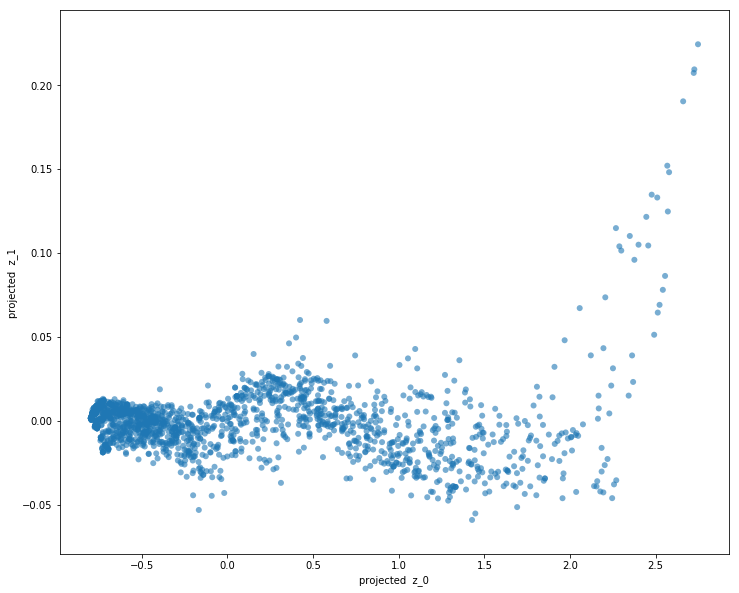

In [123]:
analyzeArgs = {"save_plots": False}


def analyze_latent_space(analyzeArgs, models,data,batch_size=128,model_name="vae_graph"):
    
    """Plots labels and data as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models  # trained models
    x_test, y_test = data

    
    ## ENCODER - 2D Digit Classes _________________________________________
    
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size = batch_size)
    
    
    ## DIMENSIONALITY REDUCTION _______________________
    
    pca = PCA(n_components=2)
    projected_z = pca.fit_transform(z_mean) 
    
    ## toDO: add t-SNE
    
    
    # Plot_____________________________
    
    #plt.figure(figsize=(12, 10))
    #plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    #plt.colorbar()
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    #plt.show()
    
    plt.figure(figsize=(12, 10))
    #plt.scatter(projected_z[:, 0], projected_z[:, 1], c=y_test[:0], edgecolor='none', alpha=0.6)
    plt.scatter(projected_z[:, 0], projected_z[:, 1], edgecolor='none', alpha=0.6)
    plt.xlabel('projected  z_0')
    plt.ylabel('projected  z_1')
    #plt.colorbar()
    
    
    if analyzeArgs["save_plots"] == True:
            os.makedirs(model_name, exist_ok=True)
            filename = os.path.join(model_name, "vae_mean.png")
            plt.savefig(filename)
            

## PLOT RESULTS ________________________________________

analyze_latent_space(analyzeArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize Latent Generative Distribution

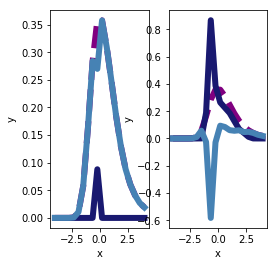

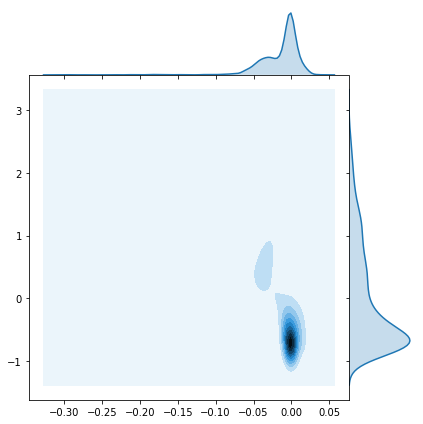

In [124]:
def visualize_latent_generative_dist(models,data,batch_size,model_name="vae_mnist"):

    encoder, decoder = models  # trained models
    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, z_log_var, z = encoder.predict(x_test, batch_size)
        
        
    ## Plot Difference Plot _______________________________
    
    normal = np.random.gumbel(0.0, 1.0, 100000)
    kde_normal = scipy.stats.gaussian_kde(normal)
    
    
    col_titles = ['z_{}'.format(col) for col in range(z_mean.shape[1])]
        

    for i in range(1, modelArgs["latent_dim"]+1):

        fig = plt.subplot(1, modelArgs["latent_dim"]+1, i)

        plt.xlabel('x')
        plt.ylabel('y')
        grid = np.linspace(-4,4, 20)
        kde_z = scipy.stats.gaussian_kde(z_mean[:,i-1])
        
        plt.plot(grid, kde_normal(grid), label="Gaussian prior", color='purple', linestyle='dashed', markerfacecolor='blue', linewidth=6)
        plt.plot(grid, kde_z(grid), label="z", color='midnightblue', markerfacecolor='blue', linewidth=6)
        plt.plot(grid, kde_normal(grid)-kde_z(grid), label="difference", color='steelblue', linewidth=6)
        

        
        
    ## Plot Joint Distribution Plot _______________________________

    ## outline how much learned variables deviates from normal distribution
    g = sns.jointplot(z_mean[:,0], z_mean[:,1], kind="kde", space=0)

    
visualize_latent_generative_dist(models,data,trainArgs["batch_size"],model_name="vae_mnist")

# Decoder

## Generate a Single Graph Instance

latent dimensions: 2


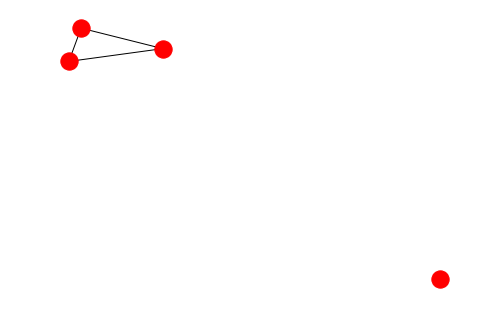

In [130]:
## apply decoder and generate data

def generate_single_instance(analyzeArgs, modelArgs, models, data, batch_size=128, model_name="vae_mlp"):
    
    print("latent dimensions:", modelArgs["latent_dim"])
    
    z_sample = np.zeros(modelArgs["latent_dim"])
    z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))
    
                
    for i, dim in enumerate(analyzeArgs["variables"]):
        z_sample[0][dim] = analyzeArgs["activations"][i]
    
    x_decoded = decoder.predict(z_sample)
    
    ## reconstruct upper triangular adjacency matrix
    reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])
    reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])
        
    ## reconstruct graph
    g = nx.from_numpy_matrix(reconstructed_a)
    #reconstructed_a = nx.adjacency_matrix(g).todense()
       
    nx.draw(g)
    

analyzeArgs = {"activations": [4, -3], "variables": [0,1]}
generate_single_instance(analyzeArgs, modelArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Generate Interpolated Manifold from Latent Space

latent dimensions: 2


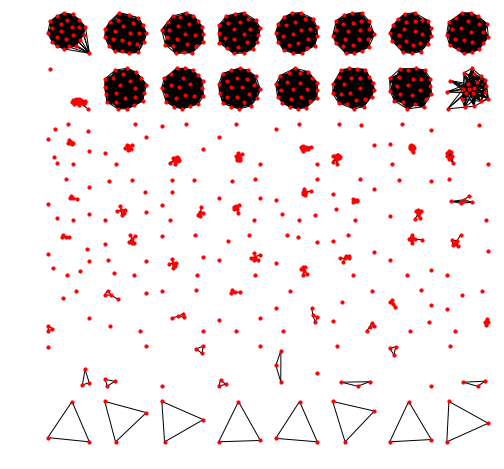

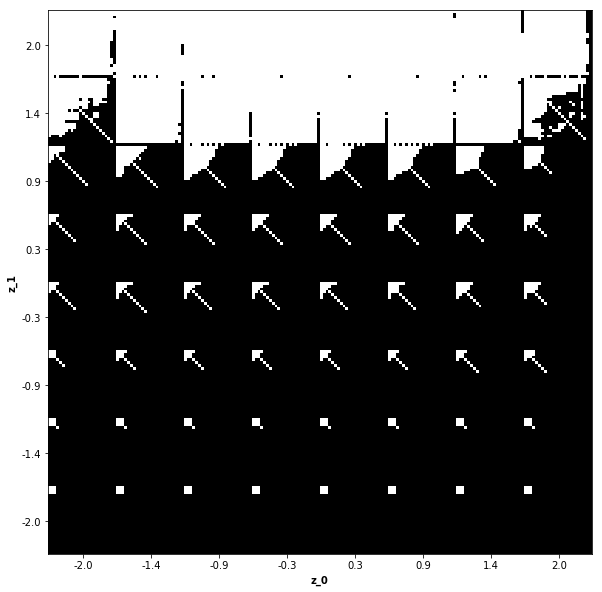

In [139]:
## DECODER - Latent Space Interpolation____________________________

def generate_interpolation_data(analyzeArgs, modelArgs, dataArgs, models, data, batch_size=128, model_name="vae_mlp"):
    
    print("latent dimensions:", modelArgs["latent_dim"])
    
    
    ## Latent Space Dimension is 1 ______________________
        
    if modelArgs["latent_dim"] == 1:
        
        ## 1) create adjacency plots__________________________________________
            
        # display a 30x30 2D manifold of digits
        n = dataArgs["n_max"]  # number of nodes
        figure = np.zeros((1 * n, analyzeArgs["size_of_manifold"] * n))
                
        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1], analyzeArgs["size_of_manifold"])
        
        z_sample = np.zeros(modelArgs["latent_dim"])
        z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))
                
       
        ## 2) create graph plots_______________________________________________
        
        fig, axs = plt.subplots(1,analyzeArgs["size_of_manifold"], figsize=(10, 10))
        #fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
         
        
        for j, xi in enumerate(grid_x):
                                                   
            z_sample[0][0] = xi**analyzeArgs["act_scale"]
            x_decoded = decoder.predict(z_sample)

            ## reconstruct upper triangular adjacency matrix
            reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])

            
            ## 1) create adjacency plot_____________________________

            figure[0:n, j * n: (j + 1) * n] = reconstructed_a
            
            
            
            ## 2) create graph plot_____________________________  
            
            # reconstruct graph
            reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])
            g = nx.from_numpy_matrix(reconstructed_a)
            reconstructed_a = nx.adjacency_matrix(g).todense()
            
            # compute index for the subplot, and set this subplot as current
            jx = np.unravel_index(j, axs.shape)
            plt.sca(axs[jx])

            nx.draw(g, node_size = 10)
            axs[jx].set_axis_off()
            axs[jx].set(ylabel='z_0')
            

                
        start_range = n // 2
        end_range = (analyzeArgs["size_of_manifold"] - 1) * n + start_range + 1
        pixel_range = np.arange(start_range, end_range, n)
        sample_range_x = np.round(grid_x, 1)


        # Plot_____________________________

        plt.figure(figsize=(15, 300))
        plt.xticks(pixel_range, sample_range_x)
        plt.xlabel("z_0", fontweight='bold')
        plt.imshow(figure, cmap='Greys_r')
        plt.show()

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename) 


            


            
            
    
    ## Latent Space Dimension is 2 ______________________
    
    if modelArgs["latent_dim"] == 2:
        
        
        ## 1) create adjacency plots_______________________________________________
        
        # display a 30x30 2D manifold of digits
        n = dataArgs["n_max"]  # number of nodes
        figure = np.zeros((analyzeArgs["size_of_manifold"] * n, analyzeArgs["size_of_manifold"] * n))
    
        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1], analyzeArgs["size_of_manifold"])
        grid_y = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1], analyzeArgs["size_of_manifold"])[::-1] ## revert
        
        
        
        ## 2) create graph plots_______________________________________________
        
        fig, axs = plt.subplots(analyzeArgs["size_of_manifold"], analyzeArgs["size_of_manifold"], figsize=(8, 8))
        #fig.subplots_adjust(hspace = .5, wspace=.001)


        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                

                xi_value = xi**analyzeArgs["act_scale"]
                yi_value = yi**analyzeArgs["act_scale"]
                
                z_sample = np.array([[xi_value, yi_value]])
                x_decoded = decoder.predict(z_sample)
                
                ## reconstruct upper triangular adjacency matrix
                reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])
                
                
                ## 1) create adjacency plots_____________________________________
                
                figure[i * n: (i + 1) * n,
                       j * n: (j + 1) * n] = reconstructed_a    
                
                ## 2) create graph plot_____________________________  
                                    
                ## reconstruct graph
                reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])
                g = nx.from_numpy_matrix(reconstructed_a)
                
                if len(g) > 0:
                    reconstructed_a = nx.adjacency_matrix(g).todense()
            
                # compute index for the subplot, and set this subplot as current
                plt.sca(axs[i, j])
                nx.draw(g, node_size = 10)
                axs[i,j].set_axis_off()
                

        start_range = n // 2
        end_range = (analyzeArgs["size_of_manifold"] - 1) * n + start_range + 1
        pixel_range = np.arange(start_range, end_range, n)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)


        # Plot_____________________________

        plt.figure(figsize=(10, 10))
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z_0", fontweight='bold')
        plt.ylabel("z_1", fontweight='bold')
        plt.imshow(figure, cmap='Greys_r')
        plt.show()

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename) 
            
            
            
            
            
            
            
    ## Latent Space Dimension is larger than 2 ______________________
        
    if modelArgs["latent_dim"] > 2:
        
        z_sample = np.zeros(modelArgs["latent_dim"])
        z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))
        
        ## 1) create adjacency plots_______________________________________________
        
        # display a 30x30 2D manifold of digits
        n = dataArgs["n_max"]  # number of nodes
        figure = np.zeros((analyzeArgs["size_of_manifold"] * n, analyzeArgs["size_of_manifold"] * n))
    
        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        grid_x = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1], analyzeArgs["size_of_manifold"])
        grid_y = np.linspace(analyzeArgs["act_range"][0], analyzeArgs["act_range"][1], analyzeArgs["size_of_manifold"])[::-1] ## revert
        
        
        ## 2) create graph plots_______________________________________________
        
        fig, axs = plt.subplots(analyzeArgs["size_of_manifold"], analyzeArgs["size_of_manifold"], figsize=(10, 10))
        #fig.subplots_adjust(hspace = .5, wspace=.001)

        
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                
                z_sample[0][analyzeArgs["variables"][0]] = xi**analyzeArgs["act_scale"]
                z_sample[0][analyzeArgs["variables"][1]] = xi**analyzeArgs["act_scale"]
                x_decoded = decoder.predict(z_sample)
                
                ## reconstruct upper triangular adjacency matrix
                reconstructed_a = reconstruct_adjacency(x_decoded, dataArgs["clip"], dataArgs["diag_offset"])
    
                ## 1) create adjacency plot_____________________________
                
                figure[i * n: (i + 1) * n,
                       j * n: (j + 1) * n] = reconstructed_a
                
                
                                
                ## 2) create graph plot_____________________________ 
                
                ## reconstruct graph
                reconstructed_a = unpad_matrix(reconstructed_a, dataArgs["diag_value"], dataArgs["fix_n"])
                g = nx.from_numpy_matrix(reconstructed_a)
                reconstructed_a = nx.adjacency_matrix(g).todense()
            
                # compute index for the subplot, and set this subplot as current
                plt.sca(axs[i, j])
                nx.draw(g, node_size = 10)
                axs[i,j].set_axis_off()

                
        start_range = n // 2
        end_range = (analyzeArgs["size_of_manifold"] - 1) * n + start_range + 1
        pixel_range = np.arange(start_range, end_range, n)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)


        # Plot_____________________________

        plt.figure(figsize=(10, 10))
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z_0", fontweight='bold')
        plt.ylabel("z_1", fontweight='bold')
        plt.imshow(figure, cmap='Greys_r')
        plt.show()

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename) 

            
## Generate Data _______________________________________

analyzeArgs = {"variables": [0,1], "act_range": [-2, 2], "act_scale": 3, "size_of_manifold": 8, "save_plots": False}
generate_interpolation_data(analyzeArgs, modelArgs, dataArgs, models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

# To Do:

- fix latent space plot
- measure the disentanglement using MIG
- train via graph sampling for real-world graphs
- add growth of success by changing numbers on the matrix diagonal
- adjust latent correlation plot